In [1]:
# Environment
from unityagents import UnityEnvironment


import numpy as np
from collections import deque
from utils.agent import Agent

# Activate Auto-completer
%config Completer.use_jedi = False

env = UnityEnvironment(file_name='Reacher.app')

brain_name = env.brain_names[0]                     # get the default brain
brain = env.brains[brain_name]                      # save the brain name
env_info = env.reset(train_mode=True)[brain_name]   # reset the environment
num_agents = len(env_info.agents)                   # get the number of agents
action_size = brain.vector_action_space_size        # get the size of each action
states = env_info.vector_observations               # examine the state space 
state_size = states.shape[1]                        # save the state size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 5	Average Scores: 4.27
Episode 10	Average Scores: 10.16
Episode 15	Average Scores: 13.83
Episode 20	Average Scores: 17.38
Episode 25	Average Scores: 20.78
Episode 30	Average Scores: 23.25
Episode 35	Average Scores: 25.09
Episode 40	Average Scores: 26.68
Episode 45	Average Scores: 27.91
Episode 50	Average Scores: 29.00
Episode 55	Average Scores: 29.86
Episode 60	Average Scores: 30.60
Episode 65	Average Scores: 31.20
Episode 70	Average Scores: 31.73
Episode 75	Average Scores: 32.18
Episode 80	Average Scores: 32.57
Episode 85	Average Scores: 32.93
Episode 90	Average Scores: 33.23
Episode 95	Average Scores: 33.48
Episode 100	Average Scores: 33.72
Episode 100	Average Scores: 33.72

Environment solved!	Average Score: 33.72


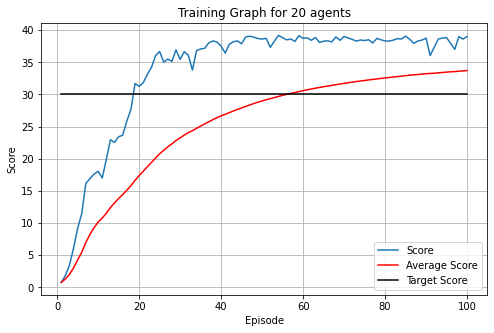

CPU times: user 1h 44min 13s, sys: 12min 47s, total: 1h 57min 1s
Wall time: 1h 47min 4s


In [2]:
%%time
def ddpg(env,num_agents,state_size,action_size,n_episodes = 500, max_t = 1000):
    scores_deque = deque(maxlen=100)
    scores = []
    
    # initiate agent
    agent = Agent(num_agents,state_size,action_size)

    for i_episode in range(1, n_episodes+1):    
        env_info = env.reset(train_mode=True)[brain_name]
        score = np.zeros(num_agents)
        agent.noise.reset()
        state = env_info.vector_observations
        for i in range(max_t):
            reward, next_state, done = agent.act(env,brain_name,state)   
            score += reward
            state = next_state
            if np.any(done):    
                break
        score = score.mean() 
        scores_deque.append(score)
        scores.append(score)
        if i_episode % agent.print_every == 0:
            agent.plotter(scores,scores_deque)
        if (np.mean(scores_deque)>=30.0) and (len(scores_deque)==100):
            # save model
            agent.save_checkpoint()
            agent.plotter(scores, solved = True, save_plot = True)        
            break
    return 

ddpg(env,num_agents,state_size,action_size)

## Watch a smart agent!

In [3]:
from utils.actorCritic import ActorPolicy, CriticPolicy
import ujson
import torch
# reset enviroment with train = False
env_info = env.reset(train_mode=False)[brain_name]    
scores = np.zeros(num_agents)    

# initiate trained network
actor_network = ujson.load(open('TrainedModel/DDPG_Actor_Network.json','r'))
trained_actor = ActorPolicy(state_size, action_size, hidden = actor_network['hidden_layers'])
state_dict_actor = torch.load('TrainedModel/DDPG_Actor.pth')
trained_actor.load_state_dict(state_dict_actor)

# set to evaluation mode
trained_actor.eval()

# loop until enviroment is done
while True:
    # take action
    with torch.no_grad():
        actions = trained_actor(env_info.vector_observations).cpu().data.numpy()
        
    # step
    env_info = env.step(actions)[brain_name]           
    next_states = env_info.vector_observations 
    
    # add scores
    scores += env_info.rewards  
    
    # check if complete
    if np.any(env_info.local_done):                                  
        break
        
print('Total score (averaged over agents) this episode: {:.2f}'.format(np.mean(scores)))
env.close()

Total score (averaged over agents) this episode: 38.39


![GIF of Trained Network](Images/ContinuousControl.gif)